# Focusing Theory figure



In [1]:
library(dplyr)
library(ggplot2)
library(cowplot)
library(magrittr)
library(tidyr)



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave


Attaching package: ‘tidyr’

The following object is masked from ‘package:magrittr’:

    extract



In [2]:
focusing = read.csv("./newdata/Enzyme_60sec.csv",header = FALSE)


In [3]:
focusing %<>% rename(Add_ATP = V1) %>% 
    mutate(Distance =seq(0,400,length.out = length(Add_ATP)) ) %>%
    filter(Distance <= 360, Distance >= 40) %>%
    mutate(Distance =seq(-160,160,length.out = length(Add_ATP)) )

In [4]:
focusing$channel[focusing$Distance <= -60] <- 'left'
focusing$channel[focusing$Distance > -60 & focusing$Distance <= 60] <- 'center'
focusing$channel[focusing$Distance > 60] <- 'right'
focusing$channel <- factor(focusing$channel, levels = c ('left','center','right'))

In [5]:
focusing %<>% mutate(Control = 0.2) %>% gather(Experiment,Concentration,Control,Add_ATP)

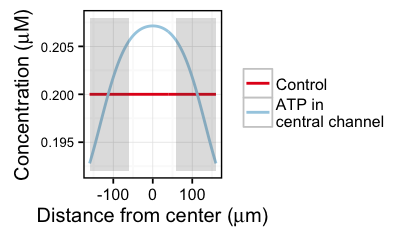

In [77]:

options(repr.plot.width = 3.5, repr.plot.height = 2)
model <- ggplot(data = focusing,aes(x = Distance,color = Experiment)) + 
    geom_line(aes(y = Concentration),size=.8) +
    theme_bw() +
xlab(expression(paste("Distance from center (", mu, "m)", sep = ""))) +
ylab(expression(paste("Concentration (", mu, "M)", sep = ""))) +
theme(panel.border = element_rect(size = .8, colour = "black"),
         axis.text.y = element_text(size=8),
         legend.title=element_blank(),
         strip.text = element_text(size = 9, vjust = -150),
         strip.background = element_rect(fill = NA, size = NA),
         panel.grid.major = element_line()) +
    annotate("rect", xmin = -160, xmax = -60, ymin = 0.192, ymax = +.208, alpha = .2) +
    annotate("rect", xmin = 60, xmax = 160, ymin = 0.192, ymax = +.208, alpha = .2) +
    scale_color_manual(values = c ("#e41a1c","#a6cee3"),labels = c("Control","ATP in\ncentral channel"))

print(model)

#### Getting Experimental Data

In [7]:
bychannel <- focusing %>% group_by(Experiment,channel) %>%
    summarise(concentration = sum(Concentration))

bychannel %<>% group_by(Experiment) %>% mutate(normalized = concentration / sum(concentration))
bychannel

,Experiment,channel,concentration,normalized
1,Control,left,10,0.3125
2,Control,center,12,0.375
3,Control,right,10,0.3125
4,Add_ATP,left,9.993177,0.3085717
5,Add_ATP,center,12.39892,0.3828566
6,Add_ATP,right,9.993177,0.3085717


In [8]:
bychannel_recap <- read.csv("./bychannel_recap.csv")

In [9]:
exp.df <- select(filter(bychannel_recap,Substrate == 'DG'),channel,Experiment,orig,smooth,lo,hi)

In [10]:
exp.df %<>% rename(concentration = smooth)

### Plotting histogram for theoretical data

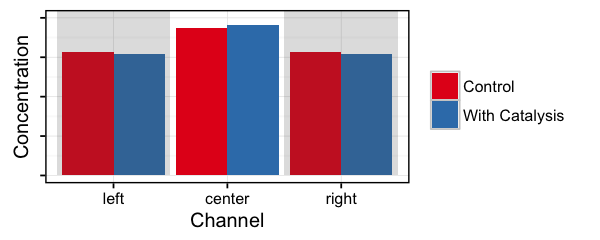

In [11]:
options(repr.plot.width = 5, repr.plot.height = 2)
integrated <- ggplot(data = bychannel , 
                     aes(x=channel, y=normalized, fill = Experiment)) + 
    geom_bar(stat = 'identity',position = 'dodge') +
    xlab("Channel") +
    ylab("Concentration") +
    theme_bw() +
    theme(panel.border = element_rect(size = .8, colour = "black"),
         axis.text.y = element_text(size=0),
         legend.title=element_blank(),
         strip.text = element_text(size = 9, vjust = -150),
         strip.background = element_rect(fill = NA, size = NA),
         panel.grid.major = element_line()) + 
    annotate("rect", xmin = 0.5, xmax = 1.5, ymin = 0, ymax = +0.5, alpha = .2) +
    annotate("rect", xmin = 2.5, xmax = 3.5, ymin = 0, ymax = +.55, alpha = .2) +
        coord_cartesian(ylim = c(0., .4)) +
    scale_fill_brewer(palette = "Set1",labels = c("Control","With Catalysis"))

print(integrated)

### Plotting Comparison Histogram
First we need to merge the data frames then plot a joined histogram.

In [12]:
tot.df <- full_join(exp.df,bychannel)

Joining by: c("channel", "Experiment", "concentration")
Warning message:
In outer_join_impl(x, y, by$x, by$y): joining factors with different levels, coercing to character vectorWarning message:
In outer_join_impl(x, y, by$x, by$y): joining factors with different levels, coercing to character vector

In [13]:
tot.df$Experiment.Type = c("exp","exp","exp","exp","exp","exp","theo","theo","theo","theo","theo","theo")

In [14]:
center.tot.df <- filter(tot.df,channel == 'center') %>% 
    group_by(Experiment.Type) %>% mutate(normalized = concentration / min(concentration))
glimpse(center.tot.df)

Observations: 4
Variables: 8
$ channel         (chr) "center", "center", "center", "center"
$ Experiment      (chr) "Control", "Add_ATP", "Control", "Add_ATP"
$ orig            (dbl) 0.004147078, 0.004772910, NA, NA
$ concentration   (dbl) 0.004153345, 0.004769103, 12.000000000, 12.398915206
$ lo              (dbl) 0.003986157, 0.004544491, NA, NA
$ hi              (dbl) 0.004323145, 0.005082040, NA, NA
$ normalized      (dbl) 1.000000, 1.148256, 1.000000, 1.033243
$ Experiment.Type (chr) "exp", "exp", "theo", "theo"


In [15]:
center.grouped.df <- center.tot.df

In [16]:
center.grouped.df %<>% mutate( Experiment.Grouped = paste(Experiment.Type,Experiment,sep="."))

In [17]:
head(center.grouped.df)

,channel,Experiment,orig,concentration,lo,hi,normalized,Experiment.Type,Experiment.Grouped
1,center,Control,0.004147078,0.004153345,0.003986157,0.004323145,1,exp,exp.Control
2,center,Add_ATP,0.00477291,0.004769103,0.004544491,0.00508204,1.148256,exp,exp.Add_ATP
3,center,Control,NA,12,NA,NA,1,theo,theo.Control
4,center,Add_ATP,NA,12.39892,NA,NA,1.033243,theo,theo.Add_ATP


In [18]:
center.tot.df$Experiment <- factor(center.tot.df$Experiment, levels = c ('Control','Add_ATP'))

In [19]:
center.grouped.df$Experiment.Grouped <- 
    factor(center.grouped.df$Experiment.Grouped, levels = c ("exp.Control","exp.Add_ATP","theo.Control","theo.Add_ATP"))

In [20]:
head(center.grouped.df)

,channel,Experiment,orig,concentration,lo,hi,normalized,Experiment.Type,Experiment.Grouped
1,center,Control,0.004147078,0.004153345,0.003986157,0.004323145,1,exp,exp.Control
2,center,Add_ATP,0.00477291,0.004769103,0.004544491,0.00508204,1.148256,exp,exp.Add_ATP
3,center,Control,NA,12,NA,NA,1,theo,theo.Control
4,center,Add_ATP,NA,12.39892,NA,NA,1.033243,theo,theo.Add_ATP


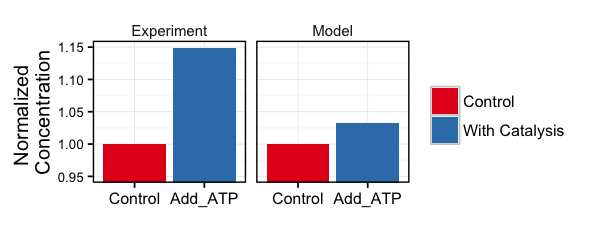

In [21]:
options(repr.plot.width = 5, repr.plot.height = 2)
comparison <- ggplot(data = center.tot.df , 
                     aes(x=Experiment, y=normalized, fill = Experiment)) + 
    geom_bar(stat = 'identity',position = 'dodge') +
    xlab("") +
    ylab("Normalized \nConcentration") +
    theme_bw() +
    coord_cartesian(ylim = c(0.95, 1.15))  +
    facet_grid(. ~Experiment.Type,
               labeller = labeller(Experiment.Type =c(exp = 'Experiment',theo = 'Model'))) +
    theme(panel.border = element_rect(size = .8, colour = "black"),
         axis.text.y = element_text(size=8),
         legend.title=element_blank(),
         strip.text = element_text(size = 9, vjust = -150),
         strip.background = element_rect(fill = NA, size = NA),
         panel.grid.major = element_line())  +
scale_fill_brewer(palette = "Set1",labels = c("Control","With Catalysis"))

print(comparison)

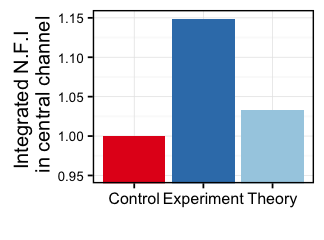

In [22]:
options(repr.plot.width = 2.7, repr.plot.height = 2)
comparison.single <- ggplot(data = filter(center.grouped.df,Experiment.Grouped != "theo.Control") , 
                     aes(x=Experiment.Grouped, y=normalized, fill = Experiment.Grouped)) + 
    geom_bar(stat = 'identity',position = 'dodge') +
    xlab("") +
    ylab("Integrated N.F.I \n in central channel") +
    theme_bw() +
    coord_cartesian(ylim = c(0.95, 1.15))  +
    theme(panel.border = element_rect(size = .8, colour = "black"),
         axis.text.y = element_text(size=8),
         legend.title=element_blank(),
         strip.text = element_text(size = 9, vjust = -150),
         strip.background = element_rect(fill = NA, size = NA),
         panel.grid.major = element_line())  +
# scale_fill_brewer(palette = "Set1",labels = c("Control","With Catalysis","hi"))
scale_fill_manual(values = c ("#e41a1c","#377eb8","#a6cee3"), guide = "none") +
scale_x_discrete(labels=c("Control", "Experiment", "Theory"))

print(comparison.single)

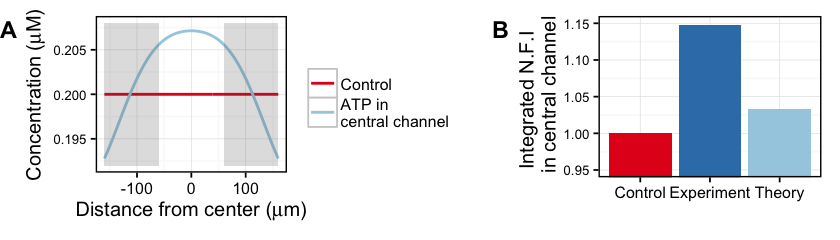

In [78]:
options(repr.plot.width = 7, repr.plot.height = 2)

plot_grid(model,comparison.single, labels = c("A","B"),ncol = 2, rel_widths = c (1.45,1),hjust = c(0,0.3),scale=.95)

In [79]:
ggsave('./img/FocusingTheoryPlot.png',width =7, height = 2)